On commence par importer les librairies nécessaires

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pulp

#### 1. Partie Commune


Génerer les noeuds et l'ensemble des arcs aléatoirement

In [8]:
N= np.random.randint(20, 100)
A= np.random.randint(50, 100)

Génerer les noeuds et l'ensemble des arcs aléatoirement

In [9]:
G=nx.gnm_random_graph(N,A,directed=True)

Identifier les boucles et les supprimer

In [10]:
boucles=list(nx.selfloop_edges(G))
G.remove_edges_from(boucles)

Afficher le graphe

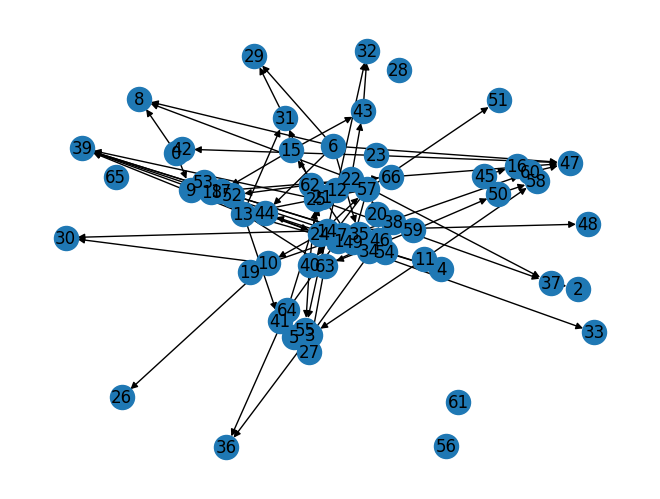

In [12]:
nx.draw_spring(G,with_labels=True)
plt.show()

Vérifier si le nombre de noeuds et le nombre d'arcs générés sont corrects.

In [13]:
print("Le nombre de noeuds initialisé est", N, "et le nombre de noeuds du graphe est:", G.number_of_nodes())
print("Le nombre d'arcs initialisé est", A, "et le nombre d'arcs du graphe est:", G.number_of_edges())

Le nombre de noeuds initialisé est 67 et le nombre de noeuds du graphe est: 67
Le nombre d'arcs initialisé est 95 et le nombre d'arcs du graphe est: 95
